# Project 1 Code: Predicting MLB Hit Outcomes


### Eddie Dew

## Problem Statement
Major League Baseball kindly decided to upload bat tracking data to their Baseball Savant csv pages. A professional baseball analyst I know decided to create a competition to have individuals try to create the best model (by AUC score) that predicts the correct batted outcome based on the new data that is provided in the [Kaggle Dataset](https://www.kaggle.com/competitions/nwds-batted-balls).

## Data
The dataset is linked above. It has a training dataset (50,000 batted ball observations) for us to create the best features and model. \\

There is also test dataset which is used for our predictions and submission. The predictions of the test dataset are scored by the AUC score and the best AUC score wins. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [2]:
predictions = pd.read_csv('test.csv')
df = pd.read_csv('train.csv')

Text(0.5, 1.0, 'Outcome Distribution')

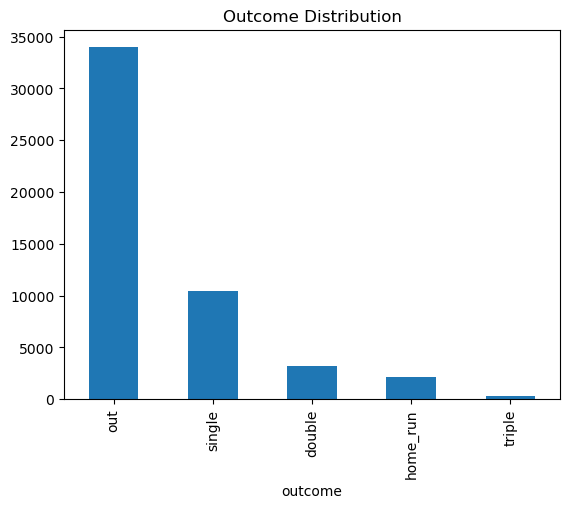

In [12]:
df['outcome'].value_counts().plot(kind='bar')
plt.title('Outcome Distribution')

Text(0.5, 1.0, 'Does Swing length and Bat speed impact outcome?')

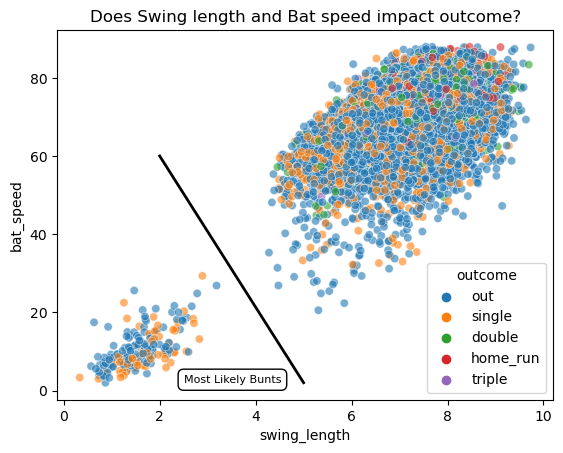

In [36]:
sns.scatterplot(data=df, x='swing_length', y='bat_speed', hue='outcome', alpha = 0.6)

ax = plt.gca()
line = plt.Line2D([2, 5], [60, 2], color='black', lw=2)
ax.add_line(line)

plt.text(2.5, 2, 'Most Likely Bunts', fontsize = 8, bbox = dict(facecolor = 'none', edgecolor = 'black', boxstyle='round,pad=0.5'))

plt.title('Does Swing length and Bat speed impact outcome?')

<Axes: xlabel='spray_angle', ylabel='release_pos_y'>

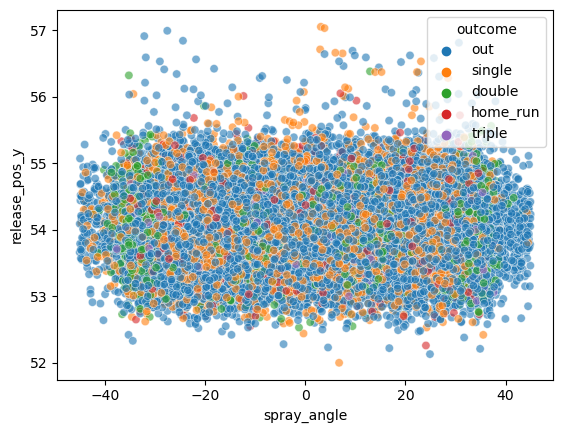

In [4]:
sns.scatterplot(x='spray_angle', y = 'release_pos_y', hue = 'outcome', data = df, alpha = 0.6)

In [44]:
df.groupby(['inning', 'outcome'])['pitch_type'].value_counts().reset_index().sort_values(by='count', ascending=False).head(20)


,inning,outcome,pitch_type,count
22,1,out,FF,1239
122,3,out,FF,1161
72,2,out,FF,1131
224,5,out,FF,1129
173,4,out,FF,1115
272,6,out,FF,1057
375,8,out,FF,1048
324,7,out,FF,1009
430,9,out,FF,916
325,7,out,SI,788


In [3]:
df.columns

Index(['uid', 'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
       'game_type', 'is_lhp', 'is_lhb', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'is_top', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'pitch_number', 'pitch_name',
       'spin_axis', 'spray_angle', 'bat_speed', 'swing_length', 'outcome',
       'outcome_code'],
      dtype='object')

In [45]:
df['swing_efficiency'] = df['bat_speed'] / df['swing_length']

df['exit_velocity'] = 0.2 * (0.92 * df['effective_speed']) + (1 + 0.2) * df['bat_speed'] #0.2 wood bat effect

df['launch_angle'] = np.arctan(df['effective_speed'] / df['exit_velocity']) * (180 / np.pi) # May need to fix

df['count_encoded'] = pd.factorize(df['balls'].astype(str) + '-' + df['strikes'].astype(str))[0] + 1
df['pitch_encoded'] = pd.factorize(df['pitch_type'])[0] + 1
df['is_bunt'] = np.where(df['swing_length'] < 4, 1, 0)

In [46]:
df.groupby('outcome')[['exit_velocity', 'launch_angle']].median()

,exit_velocity,launch_angle
outcome,,
double,103.789438,40.854004
home_run,106.109800,40.298622
out,102.002964,41.434992
single,101.835726,41.581781
triple,103.854976,41.087233


Text(0.5, 1.0, 'Approximate Exit Velocity Relation to Launch Angle')

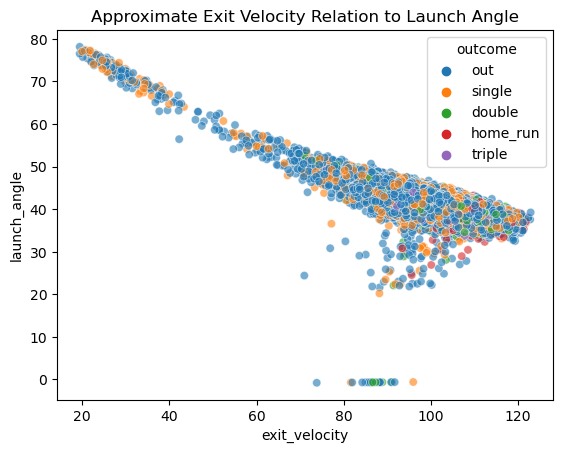

In [47]:
sns.scatterplot(x='exit_velocity', y='launch_angle', hue = 'outcome', data = df, alpha = 0.6)

plt.title('Approximate Exit Velocity Relation to Launch Angle')

Text(0.5, 1.0, 'Strike Zone and Hit Outcome')

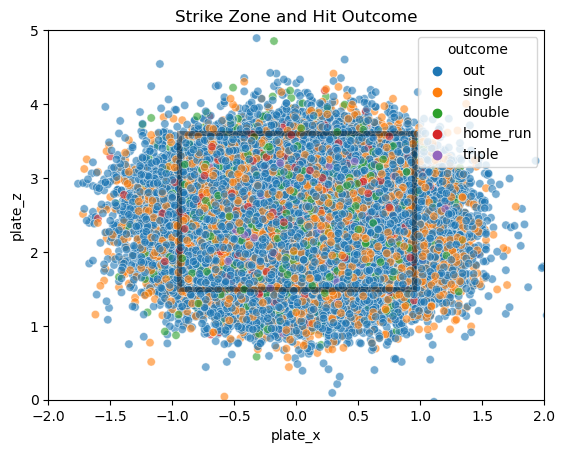

In [48]:
fig, ax = plt.subplots()
sns.scatterplot(x='plate_x', y ='plate_z', hue = 'outcome', alpha = 0.6, data = df)

plateframe = 17 + 2 * (9 / np.pi)
plate_width = plateframe / 12
plate = plt.Rectangle((-plate_width / 2, 1.5), plate_width, 3.6 - 1.5, edgecolor='black', linewidth=3.5, facecolor='none', alpha=0.4)
ax.add_patch(plate)

ax.set_ylim(0, 5)
ax.set_xlim(-2, 2)
plt.title('Strike Zone and Hit Outcome')

In [122]:
df['risp'] = np.where((df['on_2b'] != -1) | (df['on_3b'] != -1), 1, 0)


In [123]:
df['spray_angle_cat'] = [
    -3 if -45 <= angle <= -30 else
    -2 if -30 < angle <= -15 else
    -1 if -15 < angle < 0 else
     0 if angle == 0 else
     1 if 0 < angle <= 15 else
     2 if 15 < angle <= 30 else
     3 if 30 < angle <= 45 else
    np.nan  
    for angle in df['spray_angle']
]

df['is_pull'] = df.apply(lambda x: 1 if (x['is_lhb'] == 0 and x['spray_angle'] < 0) or (x['is_lhb'] == 1 and x['spray_angle'] > 0) else 0, axis=1)
df['is_empty'] = df.apply(lambda x: 1 if (x['on_1b'] == -1 and x['on_2b'] == -1 and x['on_3b'] == -1) else 0, axis = 1)
                          
                          
                          

In [ ]:
# Something to denote speed maybe?

In [124]:
features = ['release_speed', 'release_pos_x', 'release_pos_z',
       'is_lhb', 'count_encoded',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'risp','outs_when_up',
       'effective_speed', 'release_spin_rate',
       'spin_axis', 'spray_angle', 'bat_speed', 'swing_length', 
        'swing_efficiency', 'exit_velocity', 'launch_angle', 'pitch_encoded', 
        'spray_angle_cat', 'is_pull', 'is_empty', 'is_bunt']

target = 'outcome_code'


In [125]:
folds = 3
kf = KFold(folds, shuffle=True)
outputs = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(df), total=folds):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    model = XGBClassifier(objective='multi:softmax', max_depth = 6, n_estimators = 150, eta = 0.1)
    model.fit(train.loc[:, features], train[target])
    _df = pd.DataFrame(model.predict_proba(test.loc[:, features]), index=test.index)
    outputs = pd.concat([outputs, _df])


df = pd.concat([df, outputs], axis=1)
df['e'] = df.loc[:, range(5)].sum(axis=1).sub(1)
df[0] = df[0].sub(df['e'])

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


In [126]:
df = df.rename(columns={0:'out',1:'single',2:'double',3:'triple',4:'home_run'})
df.loc[:, ['uid','out','single','double','triple','home_run', target]]

,uid,out,single,double,triple,home_run,outcome_code
0,0,0.597362,0.093421,0.222677,0.024400,0.062139,0
1,1,0.768776,0.215866,0.014079,0.000385,0.000894,0
2,2,0.373541,0.604335,0.014003,0.004432,0.003689,1
3,3,0.623829,0.184671,0.069647,0.007402,0.114452,0
4,5,0.555839,0.059306,0.349564,0.030670,0.004621,1
...,...,...,...,...,...,...,...
49995,72666,0.590671,0.329224,0.043653,0.001608,0.034845,0
49996,72667,0.686693,0.276875,0.022239,0.004524,0.009669,1
49997,72668,0.729320,0.231334,0.028398,0.003394,0.007554,0
49998,72669,0.777028,0.079678,0.093909,0.004026,0.045360,2


In [127]:
roc_auc_score(df[target], df.loc[:, ['out','single','double','triple','home_run']], multi_class='ovr')

0.7145068920211313

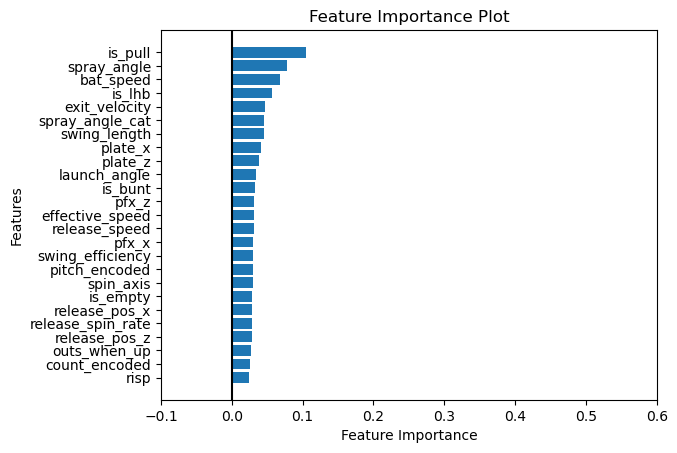

In [128]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
features = model.feature_names_in_[sorted_idx]

plt.figure()
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.axvline(x=0, color='black')
plt.xlim(-.1, .6)
plt.show()

In [7]:
pd.read_csv('sample_submission.csv')

,uid,out,single,double,triple,home_run
0,4,0.731008,0.121324,0.120257,0.002109,0.025302
1,11,0.355987,0.128842,0.450720,0.003174,0.061277
2,18,0.648896,0.255323,0.058376,0.004652,0.032753
3,19,0.762994,0.186602,0.017088,0.003890,0.029426
4,21,0.712697,0.243362,0.022308,0.003995,0.017638
...,...,...,...,...,...,...
14215,72649,0.794285,0.173273,0.015598,0.003631,0.013213
14216,72650,0.634832,0.180552,0.107084,0.011845,0.065687
14217,72651,0.651700,0.282223,0.044771,0.006487,0.014818
14218,72661,0.602370,0.232669,0.058656,0.014777,0.091527
